In [146]:
import os
import math
import requests
import pandas as pd
import numpy as np
import seaborn as sns
import geopandas as gpd
import csv
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import plotly.express as px
from statsmodels.graphics.mosaicplot import mosaic

### Notebook Constants
DATA_PATH = "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data"
COLUMNS = ['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 
            'occupation', 'relationship', 'race', 'sex', 'capital-gain', 
           'capital-loss', 'hours-per-week', 'native-country', 'salary']

In [147]:
req = requests.get(DATA_PATH)

csvreader = csv.reader(req.text, delimiter=",")

In [148]:
def dataToDict(dataText, rowdelimiter="\n", coldelimiter=", "):
    """
    Splits the rows for the data points by the rowdelimiter.
    Splits the column, row-wise 
    """
    rows = dataText.split(rowdelimiter)[:-2] # Final two rows are blank
    return {i: data.split(coldelimiter) for i, data in enumerate(rows)}

In [149]:
customer_data = dataToDict(req.text)
customer_df = pd.DataFrame.from_dict(customer_data, orient='index', columns=COLUMNS)
customer_df = customer_df.drop("fnlwgt", axis=1)
for col in ["age", "education-num", "capital-gain", "capital-loss", "hours-per-week"]: # Cast numerical columns to numerical data type
    customer_df[col] = pd.to_numeric(customer_df[col])

# Clean '?' Values
print(f"before\n {customer_df.isin(['?']).sum().sum()} values")
customer_df = customer_df.replace("?", "none")
print(f"after\n {customer_df.isin(['?']).sum().sum()} values")

before
 4262 values
after
 0 values


In [150]:
categorical_attributes = ["workclass", "education", "marital-status", "occupation", "relationship", "race", "sex", "native-country"] # These attributes are categorical data


In [151]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

name_mapping = {
    'United-States': 'United States of America',
    'Russia': 'Russian Federation',
    'Bolivia': 'Bolivia (Plurinational State of)',
    'Vietnam': 'Viet Nam',
}

customer_df['native-country'] = customer_df['native-country'].replace(name_mapping)

filtered_data = customer_df[customer_df['salary'] == '>50K']

aggregated_data = filtered_data.groupby('native-country')['salary'].count().reset_index()

merged_data = world.merge(aggregated_data, how='left', left_on='name', right_on='native-country')

merged_data['salary'] = merged_data['salary'].fillna(0)

country_to_exclude = 'United States of America'

exclude_df = merged_data[merged_data['name'] == country_to_exclude]

excluded_data = merged_data[merged_data['name'] != country_to_exclude]

added_data = excluded_data.groupby('name').sum()

exclude_df['salary'] = 0
combined_data = pd.concat([excluded_data, exclude_df])

C:\Users\aakas\miniconda3\lib\site-packages\geopandas\geodataframe.py:1351: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



C:\Users\aakas\miniconda3\lib\site-packages\geopandas\plotting.py:51: ShapelyDeprecationWarning:

The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.



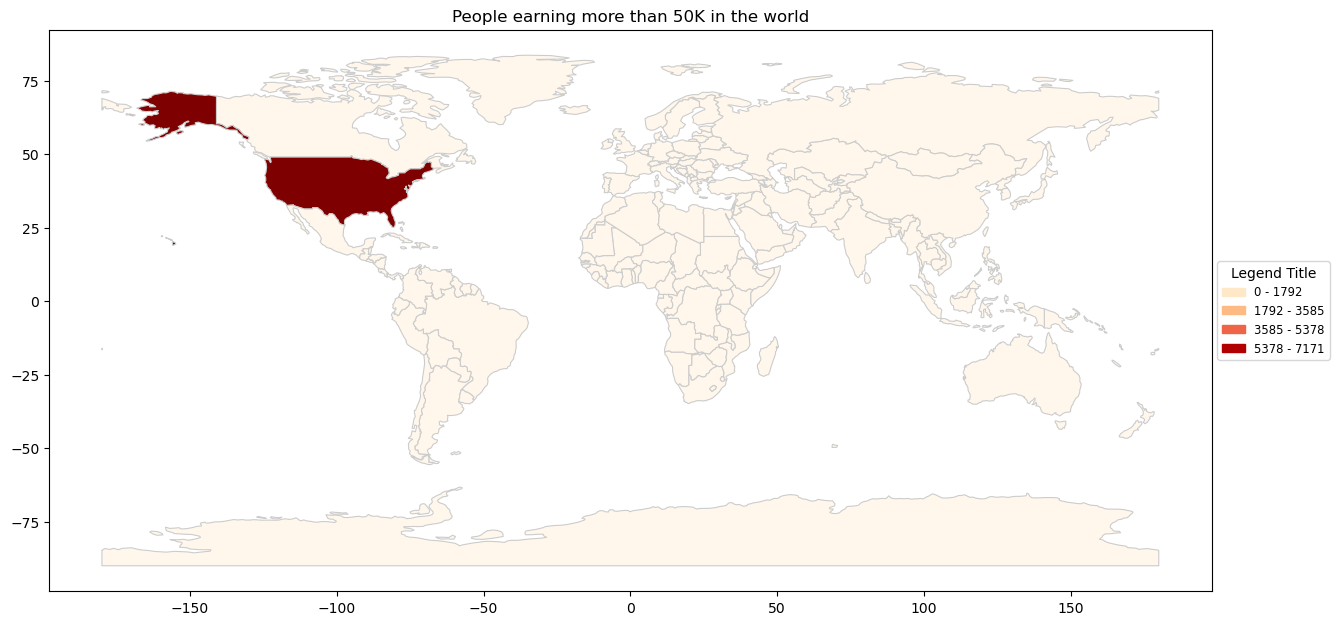

C:\Users\aakas\miniconda3\lib\site-packages\geopandas\plotting.py:51: ShapelyDeprecationWarning:

The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.



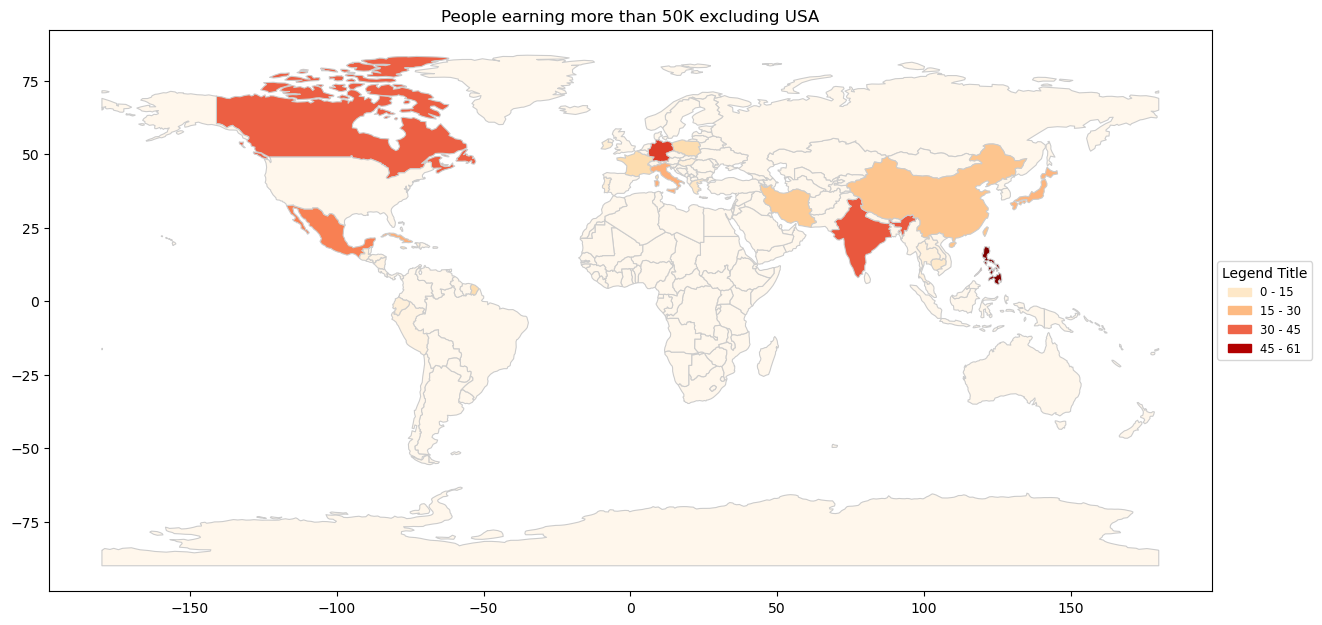

In [154]:
def create_choropleth(data, column, title, cmap='OrRd'):
    fig, ax = plt.subplots(1, 1, figsize=(15, 10))
    data.plot(column=column, 
              cmap=cmap, 
              linewidth=0.8, 
              ax=ax, 
              edgecolor='0.8')
    vmin = data[column].min()
    vmax = data[column].max()
    bins = np.linspace(vmin, vmax, 5)  # Adjust the number of bins as needed
    labels = [f'{int(bins[i])} - {int(bins[i+1])}' for i in range(len(bins)-1)]
    
    cmap = plt.get_cmap(cmap)
    norm = plt.Normalize(vmin, vmax)
    patches = [mpatches.Patch(color=cmap(norm((bins[i] + bins[i + 1]) / 2)), label=labels[i]) for i in range(len(labels))]
    
    ax.legend(handles=patches, loc='center left', bbox_to_anchor=(1, 0.5), title='Legend Title', fontsize='small')
    plt.title(title)
    plt.show()
    
create_choropleth(merged_data, 'salary', 'People earning more than 50K in the world')
create_choropleth(combined_data, 'salary', 'People earning more than 50K excluding USA')

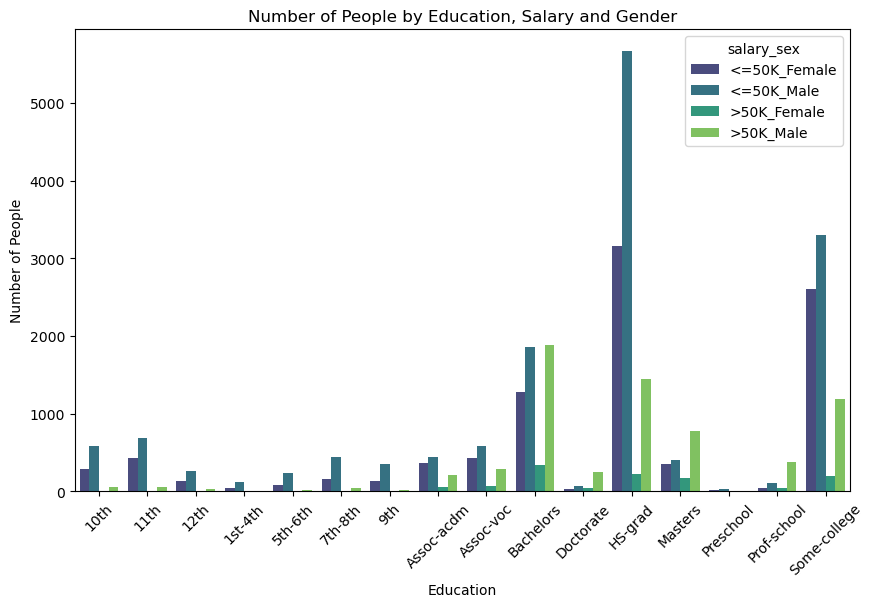

In [153]:
grouped_data = customer_df.groupby(['education', 'salary', 'sex']).size().unstack(level=['salary','sex']).fillna(0)
grouped_data_reset = grouped_data.reset_index()

grouped_data_reset.columns = ['_'.join(col).strip() for col in grouped_data_reset.columns.values]

melted_data = pd.melt(grouped_data_reset, id_vars='education_', value_vars=[('<=50K_Female'), ('<=50K_Male'), ('>50K_Female'), ('>50K_Male')], var_name=['salary_sex'], value_name='Count')

plt.figure(figsize=(10, 6))
sns.barplot(x='education_', y='Count', hue='salary_sex', data=melted_data, palette='viridis')

plt.title('Number of People by Education, Salary and Gender')
plt.xlabel('Education')
plt.xticks(rotation=45)
plt.ylabel('Number of People')
plt.show()

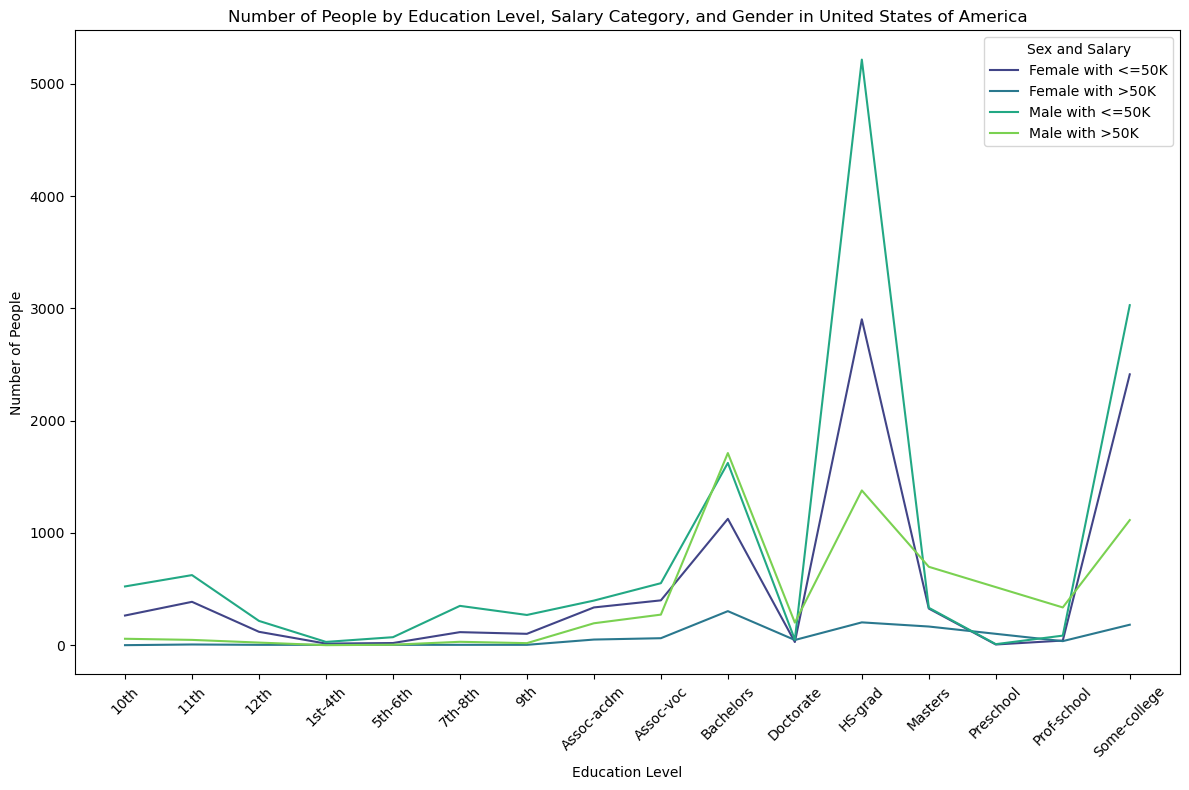

In [145]:
usa_data = customer_df[customer_df['native-country'] == 'United States of America']
customer_df['combined'] = customer_df['sex'] + ' with ' + customer_df['salary']
grouped_data = usa_data.groupby(['education', 'combined']).size().reset_index(name='Count')
plt.figure(figsize=(12, 8))
sns.lineplot(x='education', y='Count', hue='combined', data=grouped_data, palette='viridis')

# Adding titles and labels
plt.title('Number of People by Education Level, Salary Category, and Gender in United States of America')
plt.xlabel('Education Level')
plt.ylabel('Number of People')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

plt.legend(title='Sex and Salary')
plt.tight_layout()

# Show plot
plt.show()